In [1]:
import pandas as pd
df = pd.read_csv("movie_industry.csv", encoding = "latin1")

In [2]:
df["profit"] = df.apply(lambda row: row['gross'] - row['budget'], axis = 1)

In [3]:
df = df[df["budget"] != 0]

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc,recall_score,precision_score, mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.metrics import average_precision_score
from sklearn.linear_model import ElasticNetCV

In [5]:
import datetime
def weeknumber(ymd):
    try:
        arr = ymd.split("-")
        y = arr[0]
        m = arr[1]
        d = arr[2]
        return datetime.date(int(y), int(m), int(d)).isocalendar()[1]
    except:
        return -1

In [6]:
import datetime
datetime.date(5, 6, 22).isocalendar()[1]

25

In [7]:
df["weekrelease"] = df.apply(lambda row: weeknumber(row["released"]), axis = 1)

In [8]:
X = df
Y = df["gross"]
X

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year,profit,weekrelease
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986,44287414.0,34
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986,64136369.0,24
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986,164800601.0,20
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986,66660248.0,29
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986,9564613.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6808,3000000.0,Westerly Films,Ireland,Whit Stillman,Comedy,14013564.0,Love & Friendship,PG,2016-06-03,90,6.5,Kate Beckinsale,17862,Whit Stillman,2016,11013564.0,22
6809,3800000.0,Sycamore Pictures,USA,John Krasinski,Comedy,1016872.0,The Hollars,PG-13,2016-08-26,88,6.5,Sharlto Copley,7227,Jim Strouse,2016,-2783128.0,34
6811,8500000.0,CBS Films,USA,Steve Carr,Animation,19985196.0,Middle School: The Worst Years of My Life,PG,2016-10-07,92,6.1,Griffin Gluck,4556,Chris Bowman,2016,11485196.0,40
6814,20000000.0,LD Entertainment,USA,Kevin Reynolds,Action,36874745.0,Risen,PG-13,2016-02-19,107,6.3,Joseph Fiennes,19084,Kevin Reynolds,2016,16874745.0,7


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [10]:
def zscores(name, column):
    if(name in ratings):
        return ratings[name]
    else:
        up = X_train[X_train[column] == name]
#         if(len(up) < 3):
#             return 0
        mnup = np.mean(up["gross"])
        mnX = np.mean(X_train["gross"])
        std = np.std(X_train["gross"])
        ratings[name] = (mnup - mnX)/std
        return ratings[name]

In [11]:
ratings = {}
sums = {}
counts = {}
averages = {}
def reset():
    ratings = {}
    sums = {}
    counts = {}
    averages = {}

In [12]:
def add(name, column):
    if(name in sums):
        return sums[name]
    else:
        up = X_train[X_train[column] == name]
#         if(len(up) < 3):
#             return 0
        sums[name] = np.sum(up["gross"])
        return sums[name]

In [13]:
def count(name, column):
    if(name in counts):
        return counts[name]
    else:
        up = X_train[X_train[column] == name]
#         if(len(up) < 3):
#             return 0
        counts[name] = np.count_nonzero(up["gross"])
        return counts[name]

In [14]:
def avg(name, column):
    if(name in averages):
        return averages[name]
    else:
        up = X_train[X_train[column] == name]
#         if(len(up) < 3):
#             return 0
        averages[name] = np.average(up["gross"])
        return averages[name]

# Genre

In [15]:
X_train.apply(lambda row: zscores(row["genre"], "genre"), axis = 1)
results = ratings
results2 = sorted(results.items(), key=lambda x: x[1])
genre_names = []
genre_vals = []
for i in range(0,len(results2)): 
    genre_names.append(results2[i][0])
    genre_vals.append(results2[i][1])
genre_vals

[-0.5775002620439942,
 -0.5606780008462133,
 -0.5290333858684038,
 -0.5265588359756055,
 -0.3456477214940239,
 -0.3036992923156458,
 -0.29814544315772756,
 -0.22679807511178585,
 -0.2109718228272206,
 -0.15236050027187,
 -0.052581418937243836,
 -0.0017416063437180778,
 0.2860150406153136,
 0.33905150671797335,
 1.0694908428017325]

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


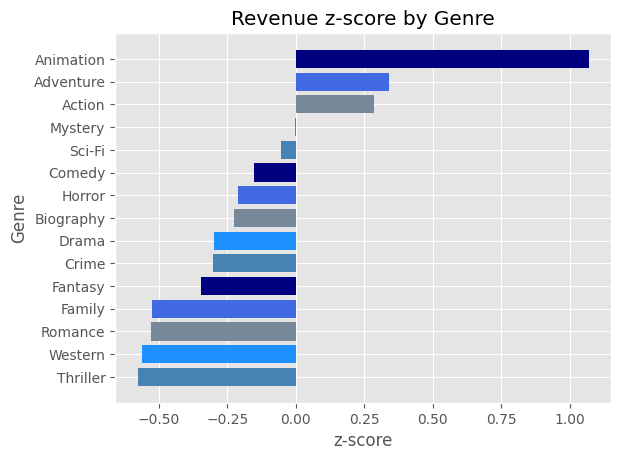

In [24]:
plt.rcdefaults()
plt.style.use('ggplot')
fig, ax = plt.subplots()

print(plt.style.available)

colors = ['steelblue', 'dodgerblue', 'lightslategray', 'royalblue', 'navy']

ax.barh(genre_names, genre_vals, color=colors)
ax.set_xlabel('z-score')
ax.set_ylabel('Genre')
ax.set_title('Revenue z-score by Genre')

plt.show()

In [25]:
len(X_train)

3478

In [310]:
X_train.apply(lambda row: add(row["genre"], "genre"), axis = 1)
results = sums
results2 = sorted(results.items(), key=lambda x: x[1])
genre_names = []
genre_vals = []
for i in range(0,len(results2)): 
    genre_names.append(results2[i][0])
    genre_vals.append(results2[i][1])
print(genre_vals)
print(genre_names)

[33882885.0, 45813634.0, 57245132.0, 293511017.0, 530977745.0, 1084779457.0, 5193035107.0, 5460251118.0, 7141966323.0, 14764669306.0, 15083001738.0, 20192047670.0, 35265752230.0, 52426655210.0]
['Romance', 'Family', 'Thriller', 'Sci-Fi', 'Fantasy', 'Mystery', 'Biography', 'Horror', 'Crime', 'Adventure', 'Drama', 'Animation', 'Comedy', 'Action']


In [311]:
genre_names1 = ['Other', 'Biography', 'Horror', 'Crime', 'Adventure', 'Drama', 'Animation', 'Comedy', 'Action']
genre_vals1 = [2046209870.0, 5193035107.0, 5460251118.0, 7141966323.0, 14764669306.0, 15083001738.0, 20192047670.0, 35265752230.0, 52426655210.0]
genre_names2 = ['Romance', 'Family', 'Thriller', 'Sci-Fi', 'Fantasy', 'Mystery']
genre_vals2 = [33882885.0, 45813634.0, 57245132.0, 293511017.0, 530977745.0, 1084779457.0]

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


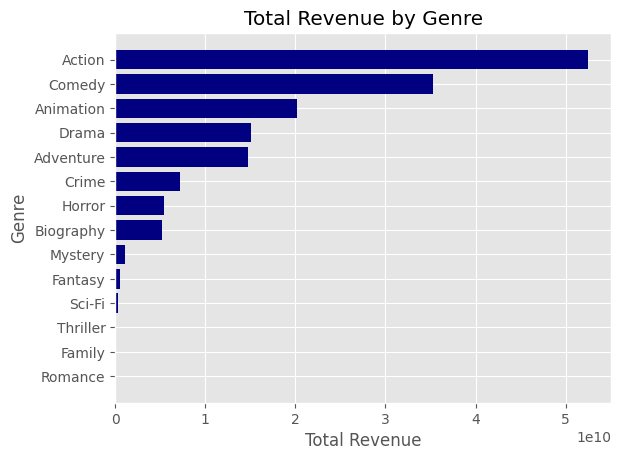

In [312]:
plt.rcdefaults()
plt.style.use('ggplot')
fig, ax = plt.subplots()

print(plt.style.available)

ax.barh(genre_names, genre_vals, color='navy')
ax.set_xlabel('Total Revenue')
ax.set_ylabel('Genre')
ax.set_title('Total Revenue by Genre')

plt.show()

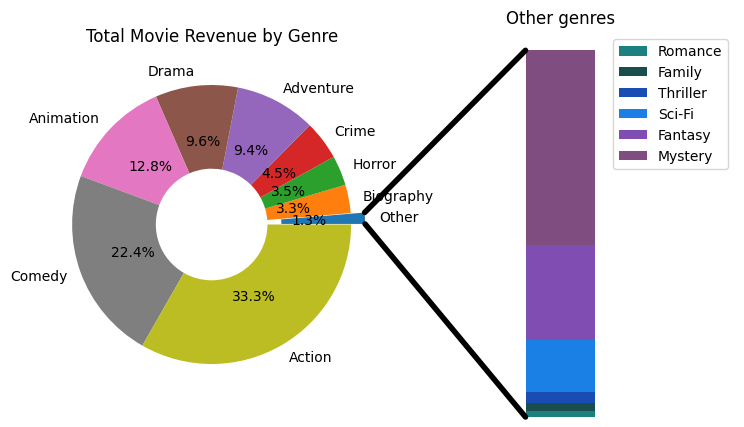

In [316]:
plt.rcdefaults()
# plt.style.use('bmh')

# make figure and assign axis objects
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0)

# pie chart parameters
ratios = genre_vals1
labels = genre_names1
explode = [0.1, 0, 0, 0, 0, 0, 0, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * ratios[0]


ax1.pie(ratios, autopct='%1.1f%%', labels=labels, wedgeprops=dict(width=0.6), explode=explode)

# bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
# kw = dict(arrowprops=dict(arrowstyle="-"),
#           bbox=bbox_props, zorder=0, va="center")

# bar chart parameters
xpos = 0
bottom = 0
ratios = genre_vals2
width = .2
colors = [[.1, .5, .5], [.1, .3, .3], [.1, .3, .7], [.1, .5, .9], [.5, .3, .7], [.5, .3, .5]]

for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
#     ax2.text(xpos, ypos, "%1.1f%%" % (ax2.patches[j].get_height()/(np.sum(genre_vals2) + np.sum(genre_vals1)) * 100),
#              ha='center')

ax2.set_title('Other genres')
ax2.legend(genre_names2)
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

ax1.set_title('Total Movie Revenue by Genre')

plt.show()

In [317]:
X_train.apply(lambda row: avg(row["genre"], "genre"), axis = 1)
results = averages
results2 = sorted(results.items(), key=lambda x: x[1])
genre_names = []
genre_vals = []
for i in range(0,len(results2)): 
    genre_names.append(results2[i][0])
    genre_vals.append(results2[i][1])
genre_vals

[8177876.0,
 11294295.0,
 11453408.5,
 23085988.913043477,
 25783271.924187727,
 26140384.294627383,
 30728018.384615384,
 31745646.034883723,
 35514352.69889224,
 41930145.28571428,
 45199144.041666664,
 63701889.68408263,
 67112133.2090909,
 114079365.36723164]

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


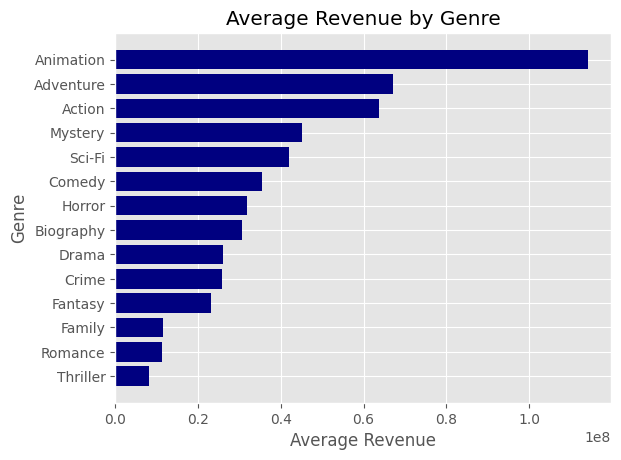

In [318]:
plt.rcdefaults()
plt.style.use('ggplot')
fig, ax = plt.subplots()

print(plt.style.available)

ax.barh(genre_names, genre_vals, color='navy')
ax.set_xlabel('Average Revenue')
ax.set_ylabel('Genre')
ax.set_title('Average Revenue by Genre')

plt.show()

# Runtime

In [26]:
averages = {}
ratings = {}
sums = {}

In [27]:
X_train.apply(lambda row: avg(row["runtime"], "runtime"), axis = 1)
results = averages
results2 = sorted(results.items(), key=lambda x: x[0])
genre_names = []
genre_vals = []
for i in range(0,len(results2)): 
    genre_names.append(results2[i][0])
    genre_vals.append(results2[i][1])
genre_names

[69,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 165,
 166,
 167,
 169,
 170,
 171,
 172,
 175,
 177,
 178,
 179,
 180,
 181,
 183,
 188,
 189,
 191,
 194,
 195,
 201,
 202,
 219,
 224,
 242,
 271,
 280]

In [28]:
len(X_test)

1160

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


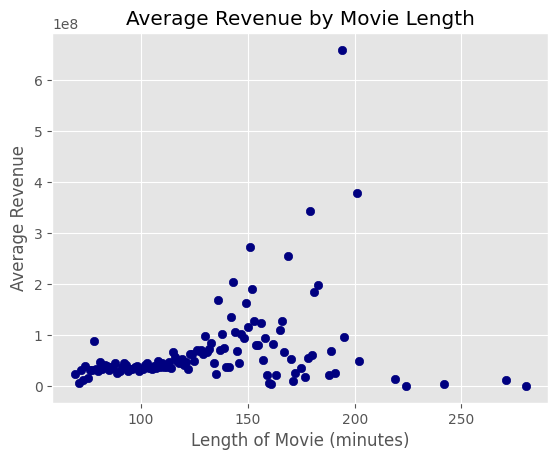

In [29]:
plt.rcdefaults()
plt.style.use('ggplot')
fig, ax = plt.subplots()

print(plt.style.available)

ax.scatter(genre_names, genre_vals, color='navy')
ax.set_xlabel('Length of Movie (minutes)')
ax.set_ylabel('Average Revenue')
ax.set_title('Average Revenue by Movie Length')

plt.show()

# Rating

In [342]:
X_train.apply(lambda row: avg(row["rating"], "rating"), axis = 1)
results = averages
results2 = sorted(results.items(), key=lambda x: x[1])
genre_names = []
genre_vals = []
for i in range(0,len(results2)): 
    genre_names.append(results2[i][0])
    genre_vals.append(results2[i][1])
genre_names

['NOT RATED', 'UNRATED', 'Not specified', 'NC-17', 'R', 'PG-13', 'PG', 'G']

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


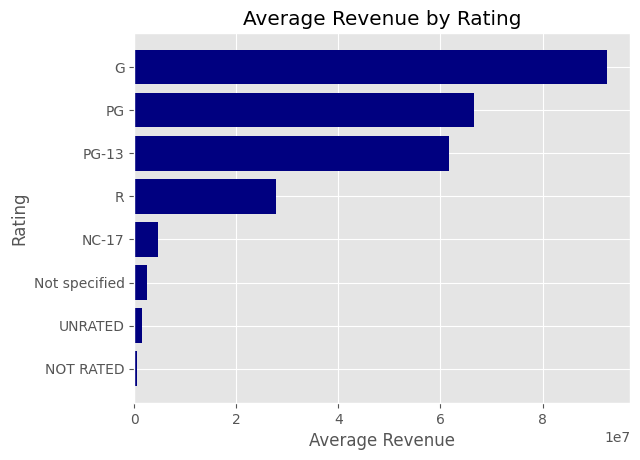

In [343]:
plt.rcdefaults()
plt.style.use('ggplot')
fig, ax = plt.subplots()

print(plt.style.available)

ax.barh(genre_names, genre_vals, color='navy')
ax.set_xlabel('Average Revenue')
ax.set_ylabel('Rating')
ax.set_title('Average Revenue by Rating')

plt.show()

In [353]:
X_train.apply(lambda row: add(row["rating"], "rating"), axis = 1)
results = sums
results2 = sorted(results.items(), key=lambda x: x[1])
genre_names = []
genre_vals = []
for i in range(0,len(results2)): 
    genre_names.append(results2[i][0])
    genre_vals.append(results2[i][1])

In [354]:
genre_names1 = ['Other', 'G', 'PG', 'R', 'PG-13']
genre_vals1 = [96678229.0, 6850039213.0, 32711849488.0, 47379940280.0, 70553600456.0]
genre_names2 = ['Not specified', 'NOT RATED', 'UNRATED', 'NC-17']
genre_vals2 = [10102546.0, 19689020.0, 24858662.0, 42028001.0]

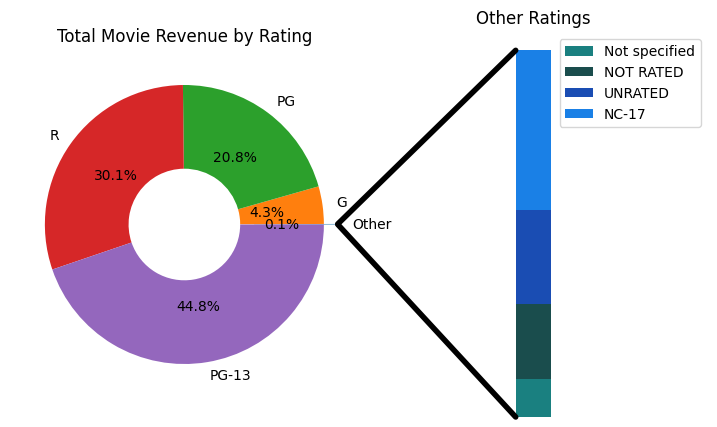

In [377]:
plt.rcdefaults()
# plt.style.use('bmh')

# make figure and assign axis objects
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0)

# pie chart parameters
ratios = genre_vals1
labels = genre_names1
explode = [0.1, 0, 0, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * ratios[0]


ax1.pie(ratios, autopct='%1.1f%%', labels=labels, wedgeprops=dict(width=0.6), explode=explode)

# bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
# kw = dict(arrowprops=dict(arrowstyle="-"),
#           bbox=bbox_props, zorder=0, va="center")

# bar chart parameters
xpos = 0
bottom = 0
ratios = genre_vals2
width = .2
colors = [[.1, .5, .5], [.1, .3, .3], [.1, .3, .7], [.1, .5, .9]]

for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
#     ax2.text(xpos, ypos, "%1.1f%%" % (ax2.patches[j].get_height()/(np.sum(genre_vals2) + np.sum(genre_vals1)) * 100),
#              ha='center')

ax2.set_title('Other Ratings')
ax2.legend(genre_names2)
ax2.axis('off')
ax2.set_xlim(- 5 * width, 5 * width)

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

ax1.set_title('Total Movie Revenue by Rating')

plt.show()

# Writer

In [70]:
X_train.apply(lambda row: add(row["writer"], "writer"), axis = 1)
results = sums
results2 = list(reversed(sorted(results.items(), key=lambda x: x[1])))
genre_names = []
genre_vals = []
ans = []
ans2 = []
for i in range(0,len(results2)): 
    genre_names.append(results2[i][0])
    genre_vals.append(results2[i][1])
    if (i < 20):
        ans.append(results2[i][0])
        ans2.append(results2[i][1])
# print(genre_names)
# print(genre_vals)
print(ans)
print(ans2)

X_train.apply(lambda row: count(row["writer"], "writer"), axis = 1)
results = counts
results2 = sorted(results.items(), key=lambda x: x[1])
genre_names2 = []
genre_vals2 = []
for i in range(0,len(results2)): 
    genre_names2.append(results2[i][0])
    genre_vals2.append(results2[i][1])
results2

['Michael Crichton', 'Melissa Rosenberg', 'John Lasseter', 'Ted Elliott', 'James Cameron', 'Lawrence Kasdan', 'Ehren Kruger', 'William Steig', 'Roberto Orci', 'Cinco Paul', 'John Hughes', 'Andrew Stanton', 'Stan Lee', 'Jonathan Nolan', 'Chris Weitz', 'J.R.R. Tolkien', 'Lilly Wachowski', 'Peter Craig', 'Bob Kane', 'Steve Kloves']
[1370767540.0, 1362206855.0, 1349823551.0, 1279221957.0, 1161427059.0, 1063162514.0, 965518830.0, 942508034.0, 852044509.0, 849533210.0, 808960928.0, 783181825.0, 777292200.0, 775968352.0, 733328677.0, 720397270.0, 713983647.0, 711046049.0, 710994320.0, 699793945.0]


[('Walter B. Gibson', 1),
 ('Ben Lewin', 1),
 ('Mike Jefferies', 1),
 ('Robert Hamner', 1),
 ('Steve James', 1),
 ('Craig Rosenberg', 1),
 ('Melissa Carter', 1),
 ('Richard Matheson', 1),
 ('Peter Young', 1),
 ('Erika Holzer', 1),
 ('Nicolás López', 1),
 ('Tobias Lindholm', 1),
 ('Kate DiCamillo', 1),
 ('Hilary Henkin', 1),
 ('Mitch Rotter', 1),
 ('Andrew Knight', 1),
 ('Jan Skrentny', 1),
 ('Laura Esquivel', 1),
 ('Lorene Scafaria', 1),
 ('Robert Pucci', 1),
 ('Joel Schumacher', 1),
 ('Robert Orr', 1),
 ('Barbara Curry', 1),
 ('Chuck Barris', 1),
 ('Will Hayes', 1),
 ('David Saperstein', 1),
 ('Todd Field', 1),
 ('James Burke', 1),
 ('Leo Garen', 1),
 ('Carole Eastman', 1),
 ('Naomi Wallace', 1),
 ('Ryan Rowe', 1),
 ('Clay Tarver', 1),
 ('Robert Sheckley', 1),
 ('Joshua Cordes', 1),
 ('Kelley Sane', 1),
 ('Ken Kolb', 1),
 ('Eric Wald', 1),
 ('Carl V. Dupré', 1),
 ('Jane Campion', 1),
 ('Bryan Bertino', 1),
 ('Graham Greene', 1),
 ('Damian Nieman', 1),
 ('Misan Sagay', 1),
 ('Walter Mo

In [66]:
averages = {}
sums = {}
counts = {}
averages

{}

In [71]:
data = {'Writer':  ans,
        'Total Revenue': ans2,
        }
df = pd.DataFrame (data, columns = ['Writer','Total Revenue'])
df.index = np.arange(1, len(df) + 1)
df

,Writer,Total Revenue
1,Michael Crichton,1.370768e+09
2,Melissa Rosenberg,1.362207e+09
3,John Lasseter,1.349824e+09
4,Ted Elliott,1.279222e+09
5,James Cameron,1.161427e+09
6,Lawrence Kasdan,1.063163e+09
7,Ehren Kruger,9.655188e+08
8,William Steig,9.425080e+08
9,Roberto Orci,8.520445e+08
10,Cinco Paul,8.495332e+08


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


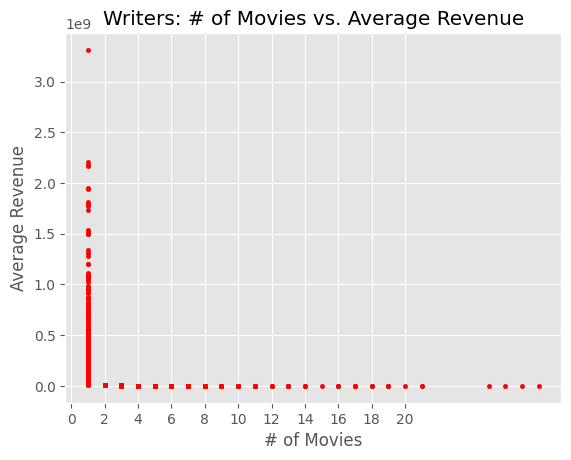

In [58]:
plt.rcdefaults()
plt.style.use('ggplot')
fig, ax = plt.subplots()

print(plt.style.available)

ax.scatter(genre_vals2, genre_vals, 3**2, 'red')
ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20])
ax.set_xlabel('# of Movies')
ax.set_ylabel('Average Revenue')
ax.set_title('Writers: # of Movies vs. Average Revenue')

plt.show()

# Director

In [1]:
sums = {}
averages = {}
counts = {}

In [48]:
X_train.apply(lambda row: add(row["director"], "director"), axis = 1)
results = sums
results2 = sorted(results.items(), key=lambda x: x[1])
genre_names = []
genre_vals = []
for i in range(0,len(results2)): 
    genre_names.append(results2[i][0])
    genre_vals.append(results2[i][1])
print(genre_vals)
X_train.apply(lambda row: count(row["director"], "director"), axis = 1)
results = counts
results2 = sorted(results.items(), key=lambda x: x[1])
genre_names2 = []
genre_vals2 = []
for i in range(0,len(results2)): 
    genre_names2.append(results2[i][0])
    genre_vals2.append(results2[i][1])
genre_vals2

[1785.0, 1800.0, 1887.0, 2034.0, 2554.0, 3478.0, 3600.0, 3607.0, 3669.0, 4106.0, 5005.0, 5176.0, 5460.0, 6911.0, 8973.0, 9122.0, 9168.0, 9837.0, 12903.0, 13133.0, 13134.0, 14904.0, 16458.0, 17472.0, 18369.0, 18469.0, 22451.0, 23563.0, 24434.0, 25369.0, 25651.0, 25775.0, 27696.0, 27766.0, 29296.0, 32630.0, 33225.0, 34321.0, 34956.0, 36497.0, 37440.0, 38108.0, 39000.0, 40179.0, 41709.0, 43061.0, 43282.0, 43671.0, 44462.0, 44785.0, 46500.0, 48034.0, 49526.0, 49620.0, 50000.0, 54207.0, 64562.0, 65804.0, 66371.0, 66637.0, 68877.0, 70147.0, 70527.0, 72273.0, 74068.0, 80026.0, 80315.0, 83361.0, 83861.0, 100144.0, 100503.0, 101228.0, 101882.0, 102118.0, 103280.0, 104401.0, 106658.0, 106869.0, 107352.0, 115103.0, 120016.0, 121885.0, 123509.0, 124494.0, 128092.0, 128486.0, 136203.0, 141626.0, 144397.0, 150277.0, 155212.0, 160641.0, 161789.0, 167723.0, 169659.0, 176305.0, 178104.0, 178160.0, 183009.0, 187112.0, 188565.0, 200399.0, 205068.0, 206128.0, 214202.0, 216781.0, 217873.0, 223537.0, 229094

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


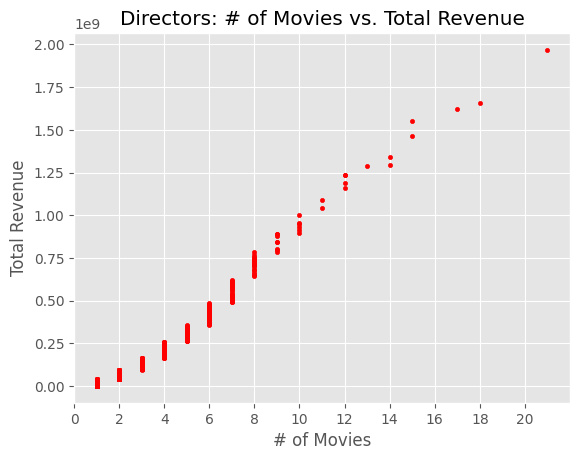

In [49]:
plt.rcdefaults()
plt.style.use('ggplot')
fig, ax = plt.subplots()

print(plt.style.available)

ax.scatter(genre_vals2, genre_vals, 3**2, 'red')
ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20])
ax.set_xlabel('# of Movies')
ax.set_ylabel('Total Revenue')
ax.set_title('Directors: # of Movies vs. Total Revenue')

plt.show()